## Generate Signal and Cov Mat for MCMC.

In [1]:
quasar_name = 'quasar_lss_all'
random_name = 'random_quasar_lss_all'
save_dir = '/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/mcmc/python/signal_small'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data_process import jackknife_label, load_calculation_data, calculate_jackknife_variance_global
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(H0=67.77, Om0=0.307115, Ob0=0.048206, Tcmb0=2.7255)
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [3]:
z = 0
scale_factor = cosmos.Om(z) * cosmos.critical_density(z).to('M_sun/pc^3').value / h**2 * 1e6

## Cross Correlation

In [4]:
r_p_cross, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_{quasar_name}_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_{random_name}_CMB_smoothed_6_tree.npy')

In [5]:
Nside_jack = 10
quasar_cata = np.load(f'../catalogue/{quasar_name}.npy')
random_sample = np.load(f'../catalogue/{random_name}.npy')

pix = jackknife_label(quasar_cata, Nside_jack)
pix_r = jackknife_label(random_sample, Nside_jack)

In [6]:
sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True, return_jackknife=True)

In [7]:
jack_cross = sampler_q['jackknife'].copy() / scale_factor

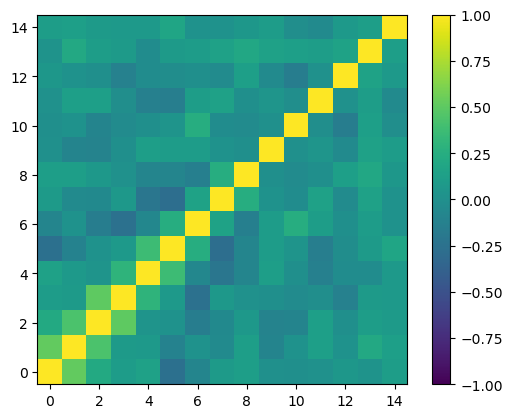

In [8]:
cov = np.cov(jack_cross, rowvar=False, ddof=0)
cov *= (jack_cross.shape[0] - 1)
std = np.sqrt([cov[i,i] for i in range(len(cov))])
cov_normed = cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

## Auto Correlation

In [9]:
Nbins = 15
rp_min = 3
rp_max = 100

rp_bin_cross = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_cross = (rp_bin_cross[:-1]*rp_bin_cross[1:])**0.5

sep = (np.log10(rp_max) - np.log10(rp_min)) / Nbins
rp_bin_auto = 10**(np.arange(-10, Nbins+1)*sep + np.log10(rp_min))
# rp_bin_auto = np.geomspace(rp_min, rp_max, Nbins+1)
r_p_auto = (rp_bin_auto[:-1]*rp_bin_auto[1:])**0.5

Nbins = len(rp_bin_auto) - 1

In [10]:
jack_auto = np.load(f'../auto_correlation/{quasar_name}_auto.npy')

## Small Scale

In [11]:
import pandas as pd
signal_s = pd.read_csv('../auto_correlation/small_scale', index_col=0)

In [12]:
signal_s = signal_s.loc[3:10, :]            # apply all the cuts.
jack_auto = jack_auto[:, 6:-2]
jack_cross = jack_cross[:, :-2]

r_p_cross = r_p_cross[:-2]
r_p_auto = r_p_auto[6:-2]
r_p_small = np.array(signal_s['rp'])

print('cross rp range ', r_p_cross[0], r_p_cross[-1])
print('auto rp range ', r_p_auto[0], r_p_auto[-1])
print('small rp range ', r_p_small[0], r_p_small[-1])
r_p_auto = np.concatenate((r_p_small, r_p_auto))

cross rp range  3.371971377818346 55.74255561017865
auto rp range  1.3236796154715165 55.74255561017865
small rp range  0.046 0.981


In [13]:
jackknife_all = np.concatenate((jack_cross, jack_auto), axis=1)
cov = np.cov(jackknife_all, rowvar=False, ddof=0)
cov *= (jackknife_all.shape[0] - 1)
std = np.sqrt([cov[i,i] for i in range(len(cov))])
cov_normed = cov / (std.reshape((-1, 1)) @ std.reshape((1, -1)))

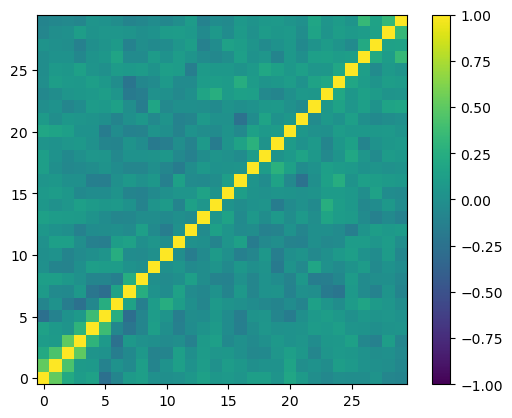

In [14]:
plt.imshow(cov_normed, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

In [15]:
w_auto = np.concatenate((signal_s['wp'], jack_auto.mean(axis=0)))
w_cross = jack_cross.mean(axis=0)

In [16]:
nc = jack_cross.shape[1]
na = jack_auto.shape[1]
ns = len(signal_s)
cov_new = np.zeros(dtype=float, shape=(nc + na + ns, )*2)
cov_new[:nc, :nc] = cov[:nc, :nc]
cov_new[-na:, -na:] = cov[-na:, -na:]
cov_new[:nc, -na:] = cov[:nc, -na:]
cov_new[-na:, :nc] = cov[-na:, :nc]
wp_s_err = np.array(signal_s['wp_err'])
for i in range(ns):
    if np.isnan(wp_s_err[i]):
        cov_new[nc+i, nc+i] = 1
    else:
        cov_new[nc+i, nc+i] = wp_s_err[i]**2

the final cov. very left: cross correlation; middle: small scale, with no covariance data; right: auto correlation.

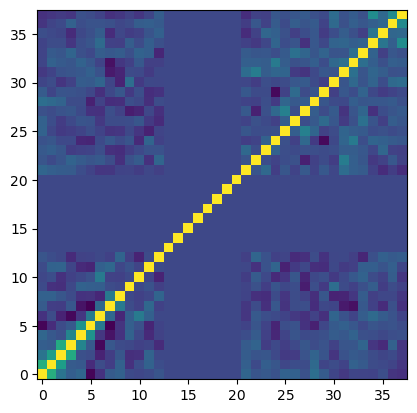

In [17]:
std_new = np.sqrt([cov_new[i,i] for i in range(len(cov_new))])
plt.imshow(cov_new / (std_new.reshape((-1, 1)) @ std_new.reshape((1, -1))), origin='lower')

In [18]:
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(f'{save_dir}/signal.npy', 'wb')  as f:
    np.save(f, r_p_auto)
    np.save(f, w_auto)
    np.save(f, r_p_cross)
    np.save(f, w_cross)
np.save(f'{save_dir}/cov', cov_new)

In [135]:
std_cross = std_new[:len(w_cross)]
std_auto = std_new[len(w_cross):]

[]

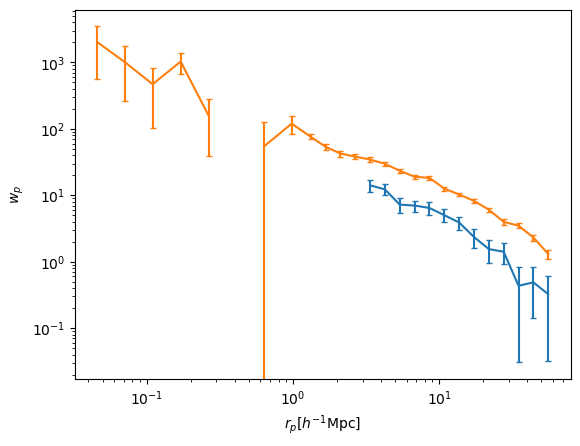

In [136]:
plt.errorbar(r_p_cross, w_cross, std_cross, capsize=2)
plt.errorbar(r_p_auto, w_auto, std_auto, capsize=2)
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel('$w_p$')
plt.loglog()

## special signal
I mutiply the auto corr cov by a factor of 1.23

In [23]:
cross_factor = 1.23

nc = jack_cross.shape[1]
na = jack_auto.shape[1]
ns = len(signal_s)
cov_new = np.zeros(dtype=float, shape=(nc + na + ns, )*2)
cov_new[:nc, :nc] = cov[:nc, :nc]
cov_new[-na:, -na:] = cov[-na:, -na:]*cross_factor
cov_new[:nc, -na:] = cov[:nc, -na:]*np.sqrt(cross_factor)
cov_new[-na:, :nc] = cov[-na:, :nc]*np.sqrt(cross_factor)
wp_s_err = np.array(signal_s['wp_err'])
for i in range(ns):
    if np.isnan(wp_s_err[i]):
        cov_new[nc+i, nc+i] = 1
    else:
        cov_new[nc+i, nc+i] = wp_s_err[i]**2

[]

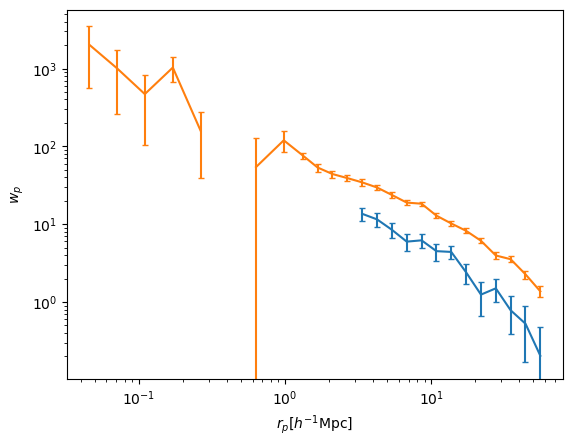

In [24]:
std_new = np.sqrt([cov_new[i,i] for i in range(len(cov_new))])
std_cross = std_new[:len(w_cross)]
std_auto = std_new[len(w_cross):]
plt.errorbar(r_p_cross, w_cross, std_cross, capsize=2)
plt.errorbar(r_p_auto, w_auto, std_auto, capsize=2)
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel('$w_p$')
plt.loglog()

In [25]:
with open('../mcmc/python/signal_small_spec2/signal.npy', 'wb')  as f:
    np.save(f, r_p_auto)
    np.save(f, w_auto)
    np.save(f, r_p_cross)
    np.save(f, w_cross)
np.save('../mcmc/python/signal_small_spec2/cov', cov_new)